In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
from datetime import datetime, timedelta

from setup.univ_setup import *
from setup.utils import *
from factor_mining.combine_factors import *
from factor_mining.factor_preprocessing import *
from factor_mining.factors.simple_factor import *
from performance_analysis.pa_core import *

from backtest.BackTestSinglePeriod import *
from backtest.BackTest import *
from backtest.percentile_portfolio import *

warnings.filterwarnings("ignore")

In [2]:
### universe setup ###
datadir = '/home/derek-qi/Documents/R3000_Data/data/r3000/'
univ = univ_setup(datadir, version=5)

Setup R3000 universe
use existing binary file


In [4]:
%%time
univ_table = stack(univ)
factors = {}
factors['net_debt_to_ebitda'] = simple_factor(univ, 'net_debt_to_ebitda')

CPU times: user 2.05 s, sys: 956 ms, total: 3 s
Wall time: 3.01 s


In [5]:
factor_names = list(factors.keys())

# concat into factor exposure matrices
factor_exp_mat = combine_factors(factors)
filt_na(factor_exp_mat)

### Filt the illiquid names within universe ###
print('Filt the untradables')
filt_byval(univ, 'in_r3000', 0)
filt_byval(univ, 'price', 10)
filt_byval(univ, 'volume', 1500000)
filt_byval(univ, 'div_ratio', 10, keep='below')

factor_exp_mat = merge(factor_exp_mat, univ, right_cols=['f_log_ret_1'])

# Preprocessing factor expsure matrices
print('Scale each factor')
factor_exp_mat = process_batch(factor_exp_mat, standardize, factor_names=factor_names)
print('Winsorize with +/- 3 std')
factor_exp_mat = process_batch(factor_exp_mat, winsorize_std, factor_names=factor_names)
print('Done')

Filt the untradables
Scale each factor
Winsorize with +/- 3 std
Done


In [7]:
datelst = sorted(univ.keys())
print(datelst[0], datelst[-1])
start_date = np.datetime64('2012-01-01')
end_date = np.datetime64('2016-12-31')

spcalc = PercentilePtflSpcalc(signal='net_debt_to_ebitda', sel_range=[90, 100])
bt = BackTest(univ, factor_exp_mat, [start_date, end_date], spcalc)
ptfl_lst, pnl_lst = bt.calc_pnl()
bt.calc_pa()

2010-10-05T00:00:00.000000000 2017-10-03T00:00:00.000000000
CAGR :	 0.0661016453328
Volatility :	 0.190465705917
Sharpe :	 0.336064033073
Max_Drawdown :	 0.497030619452
Drawdown_Length :	 1


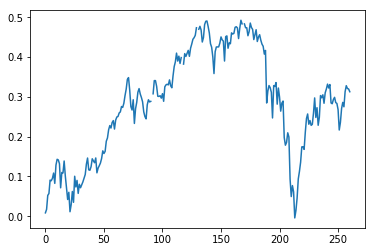

In [8]:
plt.plot(np.cumsum(pnl_lst.pnl))
plt.show()

In [9]:
%%time
from itertools import product
step = 5
ranges = [[i * step, (i + 1) * step] for i in range(100//step)]
daterange = [start_date, end_date]
config_iter = product(factor_names, ranges)
iter_result = {}
for f, g in config_iter:
    print(f,g)
    spcalc = PercentilePtflSpcalc(signal=f, sel_range=g, weighting='equal')
    bt = BackTest(univ, factor_exp_mat, daterange, spcalc)
    ptfl_lst, pnl_lst = bt.calc_pnl()
    k = f + '_' + str(g[0]) + '_' + str(g[1])
    iter_result[k] = (np.nanmean(pnl_lst.pnl), np.sqrt(np.nanvar(pnl_lst.pnl)))

net_debt_to_ebitda [0, 5]
net_debt_to_ebitda [5, 10]
net_debt_to_ebitda [10, 15]
net_debt_to_ebitda [15, 20]
net_debt_to_ebitda [20, 25]
net_debt_to_ebitda [25, 30]
net_debt_to_ebitda [30, 35]
net_debt_to_ebitda [35, 40]
net_debt_to_ebitda [40, 45]
net_debt_to_ebitda [45, 50]
net_debt_to_ebitda [50, 55]
net_debt_to_ebitda [55, 60]
net_debt_to_ebitda [60, 65]
net_debt_to_ebitda [65, 70]
net_debt_to_ebitda [70, 75]
net_debt_to_ebitda [75, 80]
net_debt_to_ebitda [80, 85]
net_debt_to_ebitda [85, 90]
net_debt_to_ebitda [90, 95]
net_debt_to_ebitda [95, 100]
CPU times: user 8min 57s, sys: 88 ms, total: 8min 57s
Wall time: 8min 57s
